<a href="https://colab.research.google.com/github/sarojkhanal-git/CBEAS_Whole_brain_and_Hippocampal_Segmentation/blob/main/Whole_brain_segmentation_SwinUNETR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries Import

In [ ]:
%pip install "monai==1.4.1rc1" -q
%pip install torchinfo -q
%pip install thop -q

In [ ]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime


import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim


from monai.config import print_config
from monai.metrics import DiceMetric
from monai.data import DataLoader, Dataset, decollate_batch
from monai.losses import DiceLoss
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    Resize,
    ScaleIntensity,
    ToTensor,
    Lambda,
    EnsureType,
)
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference


from torchinfo import summary
from thop import profile


from google.colab import drive
print_config()

MONAI version: 1.4.1rc1
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e604d1841fe60c0ffb6978ae4116535ca8d8f34f
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.0
scipy version: 1.13.1
Pillow version: 11.1.0
Tensorboard version: 2.17.1
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.47.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/e

##Drive Mount

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


##Image, Label and FreeSurferColorLUT Directory

In [ ]:
image_dir = "/content/drive/MyDrive/Datasets_for_model/resampled_image_directory"
label_dir = "/content/drive/MyDrive/Datasets_for_model/label_45_directory"

In [ ]:
lut_path = "/content/drive/MyDrive/FreeSurferColorLUT.txt"

##Image & Labels Extraction and Visualization

In [ ]:
images = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))[:250]
labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))[:250]

In [ ]:
len(images), len(labels)

(250, 250)

In [ ]:
def visualize_image(mri_image, label_image, slice_num, array = False):

  if array == False:
    mri_image = nib.load(mri_image).get_fdata()
    label_image =nib.load(label_image).get_fdata()

  df = pd.read_csv(lut_path,sep='\s+', comment = '#', names = ['Label_ID', 'Label_Name', 'R', 'G', 'B', 'A'], usecols = ['Label_ID', 'Label_Name', 'R', 'G', 'B'])

  unique_labels = np.unique(label_image)

  rgb_img = np.zeros((*label_image.shape, 3), dtype = np.uint8)

  for labels in unique_labels:
     rgb_values = df.loc[df['Label_ID'] == labels, ['R', 'G', 'B']].values[0]
     rgb_img[label_image == labels] = rgb_values

  fig, axs = plt.subplots(1, 3, figsize = (15, 15))
  axs[0].imshow(mri_image[slice_num,: ,:], cmap = 'gray')
  axs[0].set_title('MRI Slice')
  axs[0].axis('off')

  axs[1].imshow(rgb_img[slice_num, :, :, :])
  axs[1].set_title('Label Slice')
  axs[1].axis('off')

  axs[2].imshow(mri_image[slice_num, :, :], cmap = 'gray')
  axs[2].imshow(rgb_img[slice_num, :, :, :], alpha = 0.5)
  axs[2].set_title('Overlay')
  axs[2].axis('off')

  plt.show()




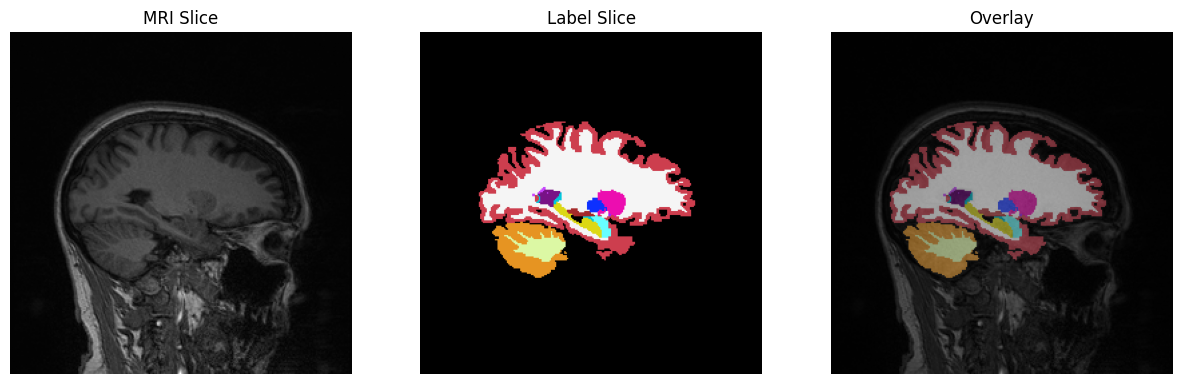

In [ ]:
visualize_image(images[245],labels[245], 110)

##Image Transforms and Custom Dataset

####Function to make labels contiguous

In [ ]:
def replace_freesurfer_index_with_contiguous(seg):
   label_index=np.unique(seg)
   for items in label_index:
     seg[seg==items]=np.where(label_index==items)[0][0]
   return seg

####Transforms

In [ ]:
img_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    ScaleIntensity(),
    EnsureChannelFirst(),
    Resize((128, 128, 128)),
])

seg_transforms = Compose([
    LoadImage(image_only=True),
    Lambda(replace_freesurfer_index_with_contiguous),
    ToTensor(),
    EnsureChannelFirst(),
    Resize((128, 128, 128), mode="nearest"),
])


In [ ]:
class MyBrainDataset(Dataset):
    def __init__(self, data, img_tfms, seg_tfms):
        super().__init__(data)
        self.img_tfms = img_tfms
        self.seg_tfms = seg_tfms

    def __getitem__(self, idx):
        d = self.data[idx]
        image = self.img_tfms(d["image"])
        label = self.seg_tfms(d["label"])
        return image, label


##Dataset Loading

In [ ]:
data_dicts = [{"image": i, "label": s} for i, s in zip(images, labels)]
train_files = data_dicts[:200]
val_files   = data_dicts[200:]

In [ ]:
train_ds = MyBrainDataset(train_files, img_transforms, seg_transforms)
val_ds   = MyBrainDataset(val_files,   img_transforms, seg_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2)

In [ ]:
def data_details (train_loader, val_loader, test_loader = None):
  print(f"Number of training samples: {len(train_loader) * train_loader.batch_size}")
  print(f"Number of validation samples: {len(val_loader) * val_loader.batch_size}")
  if test_loader:
    print(f"Number of test samples: {len(test_loader) * test_loader.batch_size}")
  train_batch = next(iter(train_loader))
  train_inputs, _ = train_batch
  print(f"Training input size: {train_inputs.shape}")

In [ ]:
data_details(train_loader, val_loader)

Number of training samples: 200
Number of validation samples: 50
Training input size: torch.Size([1, 1, 128, 128, 128])


##Model, Optimizer and Loss Function

In [ ]:
set_determinism(seed=40)

num_classes = 45

model = SwinUNETR(
    img_size=(128, 128, 128),
    in_channels=1,
    out_channels=num_classes,
).cpu()

loss_function = DiceLoss(to_onehot_y=True, sigmoid=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 50, 70], gamma=0.1)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

post_trans = Compose([Activations(sigmoid=True),
                      AsDiscrete(threshold=0.5)])


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


##Model Details

In [55]:
summary(model, input_size=(1, 1, 128, 128, 128))

In [ ]:
input_tensor = torch.randn(1, 1, 128, 128, 128)
flops, params = profile(model, inputs=(input_tensor,))
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv3d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.instancenorm.InstanceNorm3d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose3d'>.
FLOPs: 201892542000.0
Parameters: 15506349.0


##Functions to load and save model and checkpoints

In [36]:
def save_best_model(model, best_model_path):
    torch.save(model.state_dict(), best_model_path)

In [37]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [38]:
def save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path):
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'dice_mean': dice_mean,
    'epoch_list' : epoch_list,
    'val_dice_list' : val_dice_list,
    'train_loss_list' : train_loss_list,
    'best_metric': best_metric,
    'best_metric_epoch': best_metric_epoch,
    }
    torch.save(checkpoint, checkpoint_path)


In [47]:
def load_checkpoint(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    dice_mean = checkpoint['dice_mean']
    epoch_list = checkpoint['epoch_list']
    val_dice_list = checkpoint['val_dice_list']
    train_loss_list = checkpoint['train_loss_list']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    return epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch

##Load Checkpoint

In [53]:
#epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch = load_checkpoint('Path')

##Epochs and Validation

In [ ]:
max_epochs = 150
val_interval = 5

###Run if Checkpoints are not loaded

In [ ]:
train_loss_list = []
val_dice_list   = []
epoch_list      = []
dice_mean = -1
best_metric = -1
best_metric_epoch = -1

##Train and Validation Loop

In [54]:
checkpoint_path = '/content/drive/MyDrive/Checkpoints/name_Checkpoint.pth'
best_model_path = '/content/drive/MyDrive/Checkpoints/name_best_dice_model.pth'

#Training Loop
for epoch in range(max_epochs):
    print(f"Epoch [{epoch+1}/{max_epochs}] {datetime.datetime.now()}")
    model.train()
    epoch_loss = 0

    for batch_data in train_loader:
        inputs, label = batch_data[0].cuda(), batch_data[1].cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    #scheduler.step()
    train_loss_list.append(epoch_loss)
    print(f"  Train loss: {epoch_loss:.4f}")
    save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path)


    # Validation Loop
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_vals = []
        with torch.no_grad():
            val_inputs = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
                roi_size = (128, 128, 128)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)


        dice_mean = dice_metric.aggregate().item()
        dice_metric.reset()
        val_dice_list.append(dice_mean)
        epoch_list.append(epoch + 1)
        print(f"  Validation Dice: {dice_mean:.4f}")

        # Save the best model
        if dice_mean > best_metric:
            best_metric = dice_mean
            best_metric_epoch = epoch + 1
            save_best_model(model, best_model_path)
            print("   Saved new best model")


print(f"\nTraining complete. Best val Dice: {best_metric:.4f} at epoch {best_metric_epoch}")


NameError: name 'max_epochs' is not defined

##Plotting of Loss Curves

In [ ]:
len(train_loss_list), len(val_dice_list), len(epoch_list)

(0, 0, 0)

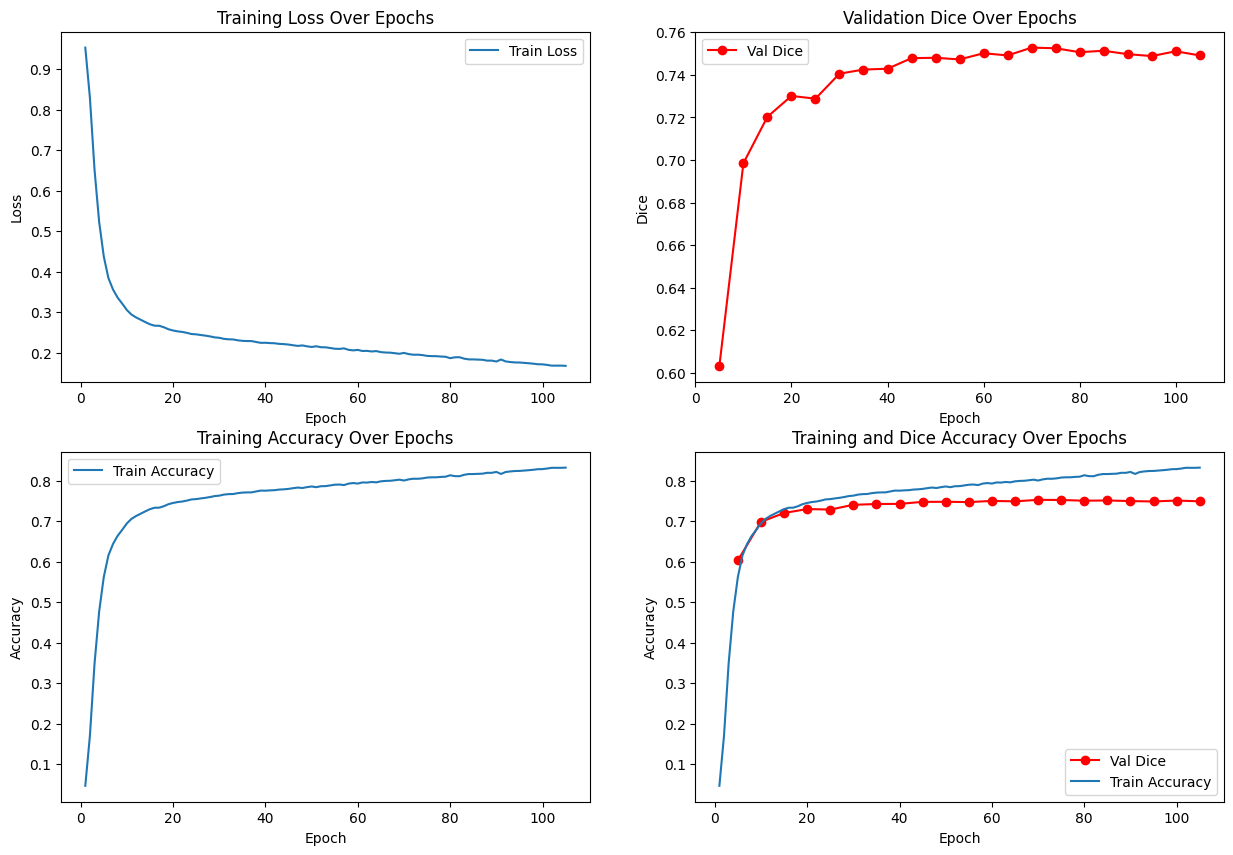

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0 ,0].plot(range(1, 106), train_loss_list, label="Train Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Training Loss Over Epochs")
axs[0, 0].legend()

axs[0, 1].plot(epoch_list, val_dice_list, 'r-o', label="Val Dice")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Dice")
axs[0, 1].set_title("Validation Dice Over Epochs")
axs[0, 1].legend()

axs[1, 0].plot(range(1, 106), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Training Accuracy Over Epochs")
axs[1, 0].legend()

axs[1, 1].plot(epoch_list, val_dice_list, 'r-o', label="Val Dice")
axs[1, 1].plot(range(1, 106), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].set_title("Training and Dice Accuracy Over Epochs")
axs[1, 1].legend()

plt.show()

##Model Evaluation

In [ ]:
load_model(model, '/content/drive/MyDrive/Checkpoints/150_epoch_1e-2_best_model.pth')

val_img, val_seg = val_ds[0]
val_img_ = val_img.unsqueeze(0).cuda()
with torch.no_grad():
    pred_logits = model(val_img_)
    pred_label  = torch.argmax(pred_logits, dim=1, keepdim=True)  # shape [1,1,D,H,W]

pred_label_np = pred_label.squeeze().cpu().numpy()  # shape [D,H,W]
val_img_np = val_img.squeeze().numpy()              # shape [D,H,W]
val_seg_np = val_seg.squeeze().numpy()              # ground truth

print("Predicted label map shape:", pred_label_np.shape)

Predicted label map shape: (128, 128, 128)


In [ ]:
print(np.unique(pred_label_np), len(np.unique(pred_label_np)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 39 40 41 42 43 44] 44


###Changing contiguous labels to standard labels

In [ ]:
STD_LABEL_VALUES = np.array([0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28, 30, 31, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60, 62, 63, 77, 80, 85, 251, 252, 253, 254, 255])

In [ ]:
std_pred_label = STD_LABEL_VALUES[pred_label_np]
std_val_seg = STD_LABEL_VALUES[val_seg_np.astype('int')]

In [ ]:
np.unique(std_pred_label)

array([  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  77,  85,
       251, 252, 253, 254, 255])

###Visualization of Predicted and Ground Truth Labels

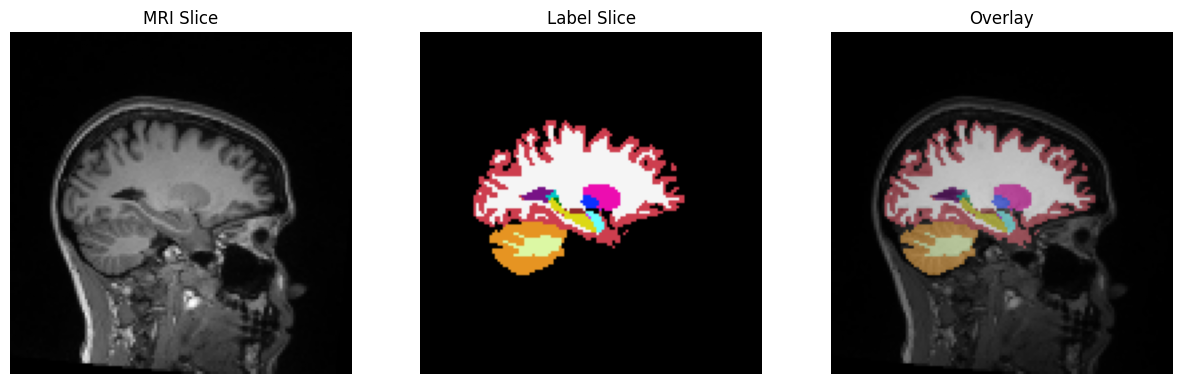

In [ ]:
#Prediction
visualize_image(val_img_np,std_pred_label, 75, array = True)

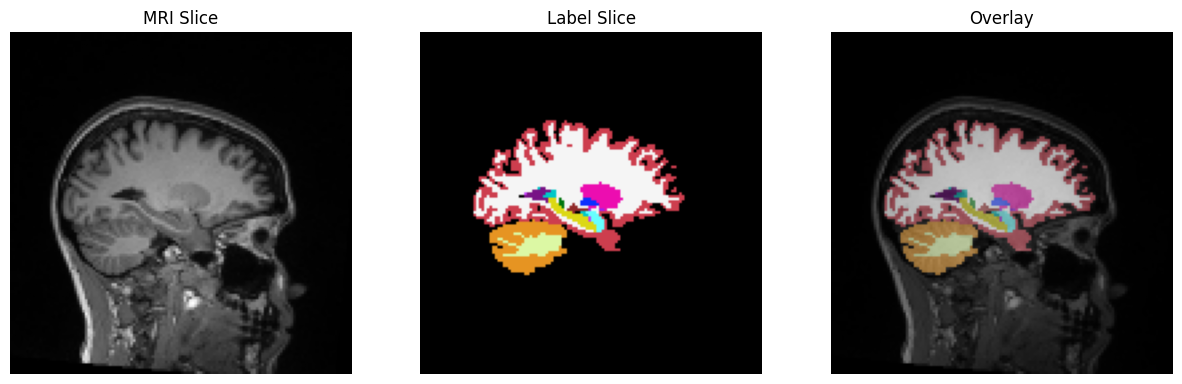

In [ ]:
#Ground Truth
visualize_image(val_img_np, std_val_seg, 75, array = True)